<a href="https://colab.research.google.com/github/Only-Mike/M2-NLP-Network-Analysis/blob/main/NLP_SC_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook for network analysis and Natural Language proccesing.

---


This note book has been created by Kasper R. Haurum, Mike Christensen, Rayian Alam and Snorre K. Brouer.

# Import dataset as df

This NEEDS to be run first before going further into the assignment

In [1]:
import pandas as pd

In [2]:
# Importing dataset

In [3]:
!git clone https://github.com/Only-Mike/M2-NLP-Network-Analysis.git

Cloning into 'M2-NLP-Network-Analysis'...
remote: Enumerating objects: 90, done.
remote: Counting objects: 100% (90/90), done.
remote: Compressing objects: 100% (88/88), done.
remote: Total 90 (delta 45), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (90/90), done.


In [4]:
data1 = pd.read_csv('/content/M2-NLP-Network-Analysis/Supply chain network - 2017 csv file.csv')
data2 = pd.read_csv('/content/M2-NLP-Network-Analysis/Supply chain network - 2018 csv file.csv')
data3 = pd.read_csv('/content/M2-NLP-Network-Analysis/Supply chain network - 2019 csv file.csv')
data4 = pd.read_csv('/content/M2-NLP-Network-Analysis/Supply chain network - 2020 csv file.csv')
data5 = pd.read_csv('/content/M2-NLP-Network-Analysis/Supply chain network - 2021 csv file.csv')


In [5]:
frames = [data1, data2, data3, data4, data5] #creating frame for all datasets

In [6]:
df = pd.concat(frames) #Concat all datasets to "df"

#Topic modelling

---


In [7]:
#Installing preprocessor to celan our text
!pip install tweet-preprocessor -q

# Installing Gensim and PyLDAvis
!pip install -qq -U gensim
!pip install -qq pyLDAvis

# explainability (why did the model say it's related to this author)
!pip install eli5

     |████████████████████████████████| 24.1 MB 29.2 MB/s 
     |████████████████████████████████| 1.7 MB 5.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 216 kB 4.7 MB/s 
     |████████████████████████████████| 133 kB 24.1 MB/s 
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107748 sha256=1a223575442564247cce95aa99e6d5c392f85017c36f14e5ea52067a8d77a359
  Stored in directory: /root/.cache/pip/wheels/cc/3c/96/3ead31a8e6c20fc0f1a707fde2e05d49a80b1b4b30096573be
Successfully built eli5
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into a

In [8]:
import numpy as np
import tqdm #progress bar
import preprocessor as prepro # text prepro

import spacy #spacy for quick language prepro
nlp = spacy.load('en_core_web_sm') #instantiating English module

# sampling, splitting
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split


# loading ML libraries
from sklearn.pipeline import make_pipeline #pipeline creation
from sklearn.feature_extraction.text import TfidfVectorizer #transforms text to sparse matrix
from sklearn.linear_model import LogisticRegression #Logit model
from sklearn.metrics import classification_report #that's self explanatory
from sklearn.decomposition import TruncatedSVD #dimensionality reduction
from xgboost import XGBClassifier

import altair as alt #viz

#explainability
import eli5
from eli5.lime import TextExplainer

# topic modeling

from gensim.corpora.dictionary import Dictionary # Import the dictionary builder
from gensim.models import LdaMulticore # we'll use the faster multicore version of LDA

# Import pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

%matplotlib inline
pyLDAvis.enable_notebook()

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


In [9]:
# prepro settings
prepro.set_options(prepro.OPT.URL, prepro.OPT.NUMBER, prepro.OPT.RESERVED, prepro.OPT.MENTION, prepro.OPT.SMILEY)

In [10]:
df.columns

Index(['Authors', 'Author(s) ID', 'Title', 'Year', 'Source title', 'Cited by',
       'DOI', 'Link', 'Affiliations', 'Authors with affiliations', 'Abstract',
       'Author Keywords', 'Index Keywords', 'Funding Details',
       'Correspondence Address', 'Publisher', 'ISSN', 'ISBN', 'CODEN',
       'Document Type', 'Source', 'EID'],
      dtype='object')

## Cleaning text and embedding the data

In [11]:
#Choosing the columns we need to work with and storing them in the value "data". This is for saving the "df" dataframe for the prediction model later on.
data = df[['Authors', 'Author(s) ID','Title', 'Abstract','Year', 'Source title']]

In [12]:
#Take a random sample of 1500 papers. This i for making the model run faster.
data = data.sample(n=1500)

In [13]:
#Making a new column called "text" from the abstract column
data['text'] = data['Abstract']

In [14]:
#Cleaning the text
data['text_clean'] = data['text'].map(lambda t: prepro.clean(t))


In [15]:
# run progress bar and clean up using spacy but without some heavy parts of the pipeline

clean_text = []

pbar = tqdm.tqdm(total=len(data['text_clean']),position=0, leave=True)

for text in nlp.pipe(data['text_clean'], disable=["tagger", "parser", "ner"]):

  txt = [token.lemma_.lower() for token in text 
         if token.is_alpha 
         and not token.is_stop 
         and not token.is_punct]

  clean_text.append(" ".join(txt))

  pbar.update(1)

  0%|          | 0/1500 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
 99%|█████████▉| 1487/1500 [00:30<00:00, 98.11it/s]

In [16]:
# write everything into a single function for simplicity later on
def text_prepro(texts):
  """
  takes in a pandas series (1 column of a DF)
  lowercases, normalizes text
  """
  texts_clean = texts.map(lambda t: prepro.clean(t))

  clean_container = []

  pbar = tqdm.tqdm(total=len(texts_clean),position=0, leave=True)

  for text in nlp.pipe(texts_clean, disable=["tagger", "parser", "ner"]):

    txt = [token.lemma_.lower() for token in text 
          if token.is_alpha 
          and not token.is_stop 
          and not token.is_punct]

    clean_container.append(" ".join(txt))
    pbar.update(1)
  
  return clean_container

In [17]:
data['text_clean'] = text_prepro(data['text'])

100%|██████████| 1500/1500 [00:29<00:00, 50.66it/s] 


In [18]:
# preprocess texts
tokens = []

for summary in nlp.pipe(data['text_clean'], disable=["ner"]):
  proj_tok = [token.lemma_.lower() for token in summary 
              if token.pos_ in ['NOUN', 'PROPN', 'ADJ', 'ADV'] 
              and not token.is_stop
              and not token.is_punct] 
  tokens.append(proj_tok)

In [19]:
data['tokens'] = tokens

In [20]:
# Create a Dictionary from the articles: dictionary
dictionary = Dictionary(data['tokens'])

# filter out low-frequency / high-frequency stuff, also limit the vocabulary to max 600 words
dictionary.filter_extremes(no_below=4, no_above=0.4, keep_n=600)

# construct corpus using this dictionary
corpus = [dictionary.doc2bow(doc) for doc in data['tokens']]

##Visualization

In [21]:
lda_model = LdaMulticore(corpus, id2word=dictionary, num_topics=13, workers = 4, passes=10)

In [22]:
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [23]:
pyLDAvis.display(lda_display)

##Model Metrics

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from gensim.models import LdaModel, CoherenceModel
from gensim import corpora

In [25]:
corpus = data['tokens']

In [26]:
corpus

1729    [energy, sector, specific, area, economy, powe...
1466    [cross, docking, logistic, management, strateg...
907     [main, purpose, paper, design, comprehensive, ...
859     [counterfeit, unapproved, drug, health, risk, ...
546     [today, scenario, manufacturing, supply, chain...
                              ...                        
255     [hydrogen, energy, important, way, carbon, emi...
980     [paper, climate, global, warming, big, current...
1227    [paper, co, production, arrangement, private, ...
843     [study, effect, relative, advantage, complexit...
1090    [purpose, nowadays, people, attention, green, ...
Name: tokens, Length: 1500, dtype: object

In [27]:
dirichlet_dict = corpora.Dictionary(corpus)
bow_corpus = [dirichlet_dict.doc2bow(text) for text in corpus]

# Considering 1-15 topics, as the last is cut off
num_topics = list(range(16)[1:])
num_keywords = 15

LDA_models = {}
LDA_topics = {}
for i in num_topics:
    LDA_models[i] = LdaModel(corpus=bow_corpus,
                             id2word=dirichlet_dict,
                             num_topics=i,
                             update_every=1,
                             chunksize=len(bow_corpus),
                             passes=20,
                             alpha='auto',
                             random_state=42)

    shown_topics = LDA_models[i].show_topics(num_topics=i, 
                                             num_words=num_keywords,
                                             formatted=False)
    LDA_topics[i] = [[word[0] for word in topic[1]] for topic in shown_topics]

In [28]:
def jaccard_similarity(topic_1, topic_2):
    """
    Derives the Jaccard similarity of two topics

    Jaccard similarity:
    - A statistic used for comparing the similarity and diversity of sample sets
    - J(A,B) = (A ∩ B)/(A ∪ B)
    - Goal is low Jaccard scores for coverage of the diverse elements
    """
    intersection = set(topic_1).intersection(set(topic_2))
    union = set(topic_1).union(set(topic_2))
                    
    return float(len(intersection))/float(len(union))

In [29]:
LDA_stability = {}
for i in range(0, len(num_topics)-1):
    jaccard_sims = []
    for t1, topic1 in enumerate(LDA_topics[num_topics[i]]): # pylint: disable=unused-variable
        sims = []
        for t2, topic2 in enumerate(LDA_topics[num_topics[i+1]]): # pylint: disable=unused-variable
            sims.append(jaccard_similarity(topic1, topic2))    
        
        jaccard_sims.append(sims)    
    
    LDA_stability[num_topics[i]] = jaccard_sims
                
mean_stabilities = [np.array(LDA_stability[i]).mean() for i in num_topics[:-1]]

In [30]:
coherences = [CoherenceModel(model=LDA_models[i], texts=corpus, dictionary=dirichlet_dict, coherence='c_v').get_coherence() for i in num_topics[:-1]]

In [31]:
coh_sta_diffs = [coherences[i] - mean_stabilities[i] for i in range(num_keywords)[:-1]] # limit topic numbers to the number of keywords
coh_sta_max = max(coh_sta_diffs)
coh_sta_max_idxs = [i for i, j in enumerate(coh_sta_diffs) if j == coh_sta_max]
ideal_topic_num_index = coh_sta_max_idxs[0] # choose less topics in case there's more than one max
ideal_topic_num = num_topics[ideal_topic_num_index]

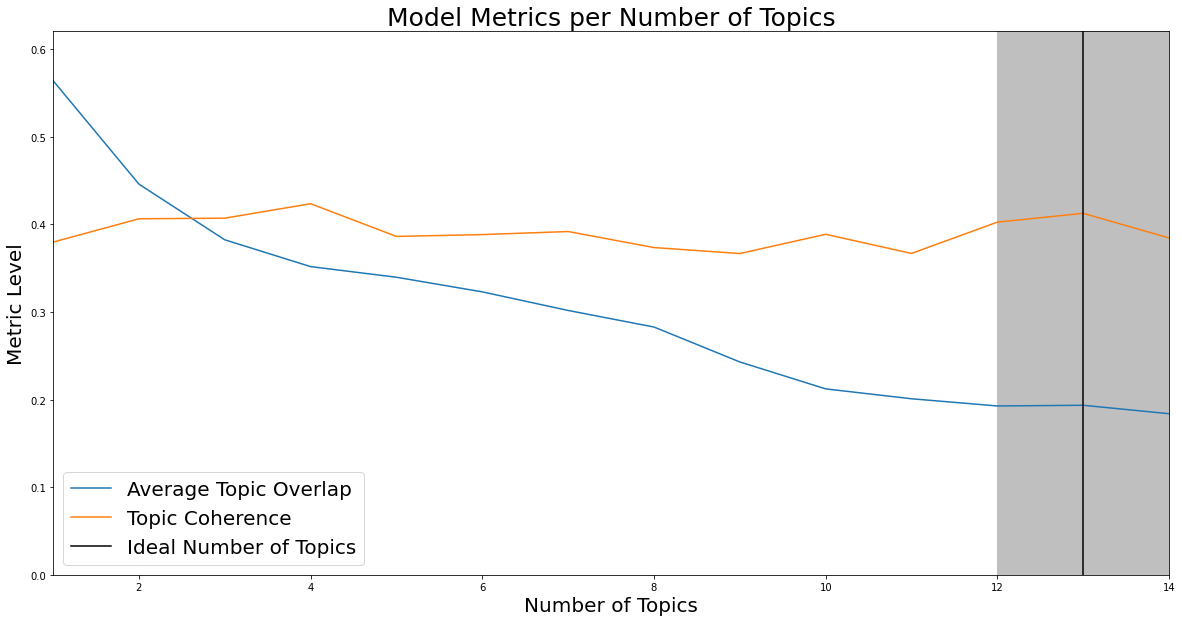

In [32]:
plt.figure(figsize=(20,10))
ax = sns.lineplot(x=num_topics[:-1], y=mean_stabilities, label='Average Topic Overlap')
ax = sns.lineplot(x=num_topics[:-1], y=coherences, label='Topic Coherence')

ax.axvline(x=ideal_topic_num, label='Ideal Number of Topics', color='black')
ax.axvspan(xmin=ideal_topic_num - 1, xmax=ideal_topic_num + 1, alpha=0.5, facecolor='grey')

y_max = max(max(mean_stabilities), max(coherences)) + (0.10 * max(max(mean_stabilities), max(coherences)))
ax.set_ylim([0, y_max])
ax.set_xlim([1, num_topics[-1]-1])
                
ax.axes.set_title('Model Metrics per Number of Topics', fontsize=25)
ax.set_ylabel('Metric Level', fontsize=20)
ax.set_xlabel('Number of Topics', fontsize=20)
plt.legend(fontsize=20)
plt.show()  

#Topics over time

---



##Topics 2017

In [33]:
#Choosing the columns we need to work with and storing them in the value "data". This is for saving the "df" dataframe for the prediction model later on.
data1 = data1[['Authors', 'Author(s) ID','Title', 'Abstract','Year', 'Source title']]

In [34]:
#Take a random sample of 500 papers. This i for making the model run faster.
data1 = data1.sample(n=500)

In [35]:
#Making a new column called "text" from the abstract column
data1['text'] = data1['Abstract']

In [36]:
#Cleaning the text
data1['text_clean'] = data1['text'].map(lambda t: prepro.clean(t))


In [37]:
# run progress bar and clean up using spacy but without some heavy parts of the pipeline

clean_text = []

pbar = tqdm.tqdm(total=len(data1['text_clean']),position=0, leave=True)

for text in nlp.pipe(data1['text_clean'], disable=["tagger", "parser", "ner"]):

  txt = [token.lemma_.lower() for token in text 
         if token.is_alpha 
         and not token.is_stop 
         and not token.is_punct]

  clean_text.append(" ".join(txt))

  pbar.update(1)

100%|██████████| 1500/1500 [13:22<00:00,  1.87it/s]
/usr/local/lib/python3.7/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
 98%|█████████▊| 490/500 [00:06<00:00, 180.70it/s]

In [38]:
# write everything into a single function for simplicity later on
def text_prepro(texts):
  """
  takes in a pandas series (1 column of a DF)
  lowercases, normalizes text
  """
  texts_clean = texts.map(lambda t: prepro.clean(t))

  clean_container = []

  pbar = tqdm.tqdm(total=len(texts_clean),position=0, leave=True)

  for text in nlp.pipe(texts_clean, disable=["tagger", "parser", "ner"]):

    txt = [token.lemma_.lower() for token in text 
          if token.is_alpha 
          and not token.is_stop 
          and not token.is_punct]

    clean_container.append(" ".join(txt))
    pbar.update(1)
  
  return clean_container

In [39]:
data1['text_clean'] = text_prepro(data1['text'])  ##<---- HVAD GØR DEN HER?<-------##

100%|██████████| 500/500 [00:05<00:00, 85.67it/s] 


In [40]:
# preprocess texts (we need tokens)  <---- Hvad gør den her? <------
tokens = []

for summary in nlp.pipe(data1['text_clean'], disable=["ner"]):
  proj_tok = [token.lemma_.lower() for token in summary 
              if token.pos_ in ['NOUN', 'PROPN', 'ADJ', 'ADV'] 
              and not token.is_stop
              and not token.is_punct] 
  tokens.append(proj_tok)

In [41]:
data1['tokens'] = tokens

In [42]:

# Create a Dictionary from the articles: dictionary
dictionary = Dictionary(data1['tokens'])

# filter out low-frequency / high-frequency stuff, also limit the vocabulary to max XXXXXXX words
dictionary.filter_extremes(no_below=4, no_above=0.4, keep_n=600)

# construct corpus using this dictionary
corpus = [dictionary.doc2bow(doc) for doc in data1['tokens']]

###Visualization

In [43]:
lda_model = LdaMulticore(corpus, id2word=dictionary, num_topics=13, workers = 4, passes=10)

100%|██████████| 500/500 [00:17<00:00, 180.70it/s]

In [44]:
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [45]:
pyLDAvis.display(lda_display)

## Topics 2018

In [46]:
#Choosing the columns we need to work with and storing them in the value "data". This is for saving the "df" dataframe for the prediction model later on.
data2 = data2[['Authors', 'Author(s) ID','Title', 'Abstract','Year', 'Source title']]

In [47]:
#Take a random sample of 500 papers. This i for making the model run faster.
data2 = data2.sample(n=500)

In [48]:
#Making a new column called "text" from the abstract column
data2['text'] = data2['Abstract']

In [49]:
#Cleaning the text
data2['text_clean'] = data2['text'].map(lambda t: prepro.clean(t))


In [50]:
# run progress bar and clean up using spacy but without some heavy parts of the pipeline

clean_text = []

pbar = tqdm.tqdm(total=len(data2['text_clean']),position=0, leave=True)

for text in nlp.pipe(data2['text_clean'], disable=["tagger", "parser", "ner"]):

  txt = [token.lemma_.lower() for token in text 
         if token.is_alpha 
         and not token.is_stop 
         and not token.is_punct]

  clean_text.append(" ".join(txt))

  pbar.update(1)

 96%|█████████▌| 481/500 [00:06<00:00, 190.58it/s]

In [51]:
# write everything into a single function for simplicity later on
def text_prepro(texts):
  """
  takes in a pandas series (1 column of a DF)
  lowercases, normalizes text
  """
  texts_clean = texts.map(lambda t: prepro.clean(t))

  clean_container = []

  pbar = tqdm.tqdm(total=len(texts_clean),position=0, leave=True)

  for text in nlp.pipe(texts_clean, disable=["tagger", "parser", "ner"]):

    txt = [token.lemma_.lower() for token in text 
          if token.is_alpha 
          and not token.is_stop 
          and not token.is_punct]

    clean_container.append(" ".join(txt))
    pbar.update(1)
  
  return clean_container

In [52]:
data2['text_clean'] = text_prepro(data2['text'])

100%|██████████| 500/500 [00:07<00:00, 64.26it/s] 


In [53]:
# preprocess texts
tokens = []

for summary in nlp.pipe(data2['text_clean'], disable=["ner"]):
  proj_tok = [token.lemma_.lower() for token in summary 
              if token.pos_ in ['NOUN', 'PROPN', 'ADJ', 'ADV'] 
              and not token.is_stop
              and not token.is_punct] 
  tokens.append(proj_tok)

100%|██████████| 500/500 [00:17<00:00, 190.58it/s]

In [54]:
data2['tokens'] = tokens

In [55]:
# Create a Dictionary from the articles: dictionary
dictionary = Dictionary(data2['tokens'])

# filter out low-frequency / high-frequency stuff, also limit the vocabulary to max 600 words
dictionary.filter_extremes(no_below=4, no_above=0.4, keep_n=600)

# construct corpus using this dictionary
corpus = [dictionary.doc2bow(doc) for doc in data2['tokens']]

###Visualization

In [56]:
lda_model = LdaMulticore(corpus, id2word=dictionary, num_topics=13, workers = 4, passes=10)

In [57]:
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)

In [58]:
pyLDAvis.display(lda_display)

##Topics 2019

In [59]:
#Choosing the columns we need to work with and storing them in the value "data". This is for saving the "df" dataframe for the prediction model later on.
data3 = data3[['Authors', 'Author(s) ID','Title', 'Abstract','Year', 'Source title']]

In [60]:
#Take a random sample of 500 papers. This i for making the model run faster.
data3 = data3.sample(n=500)

In [61]:
#Making a new column called "text" from the abstract column
data3['text'] = data3['Abstract']

In [62]:
#Cleaning the text
data3['text_clean'] = data3['text'].map(lambda t: prepro.clean(t))


In [63]:
# run progress bar and clean up using spacy but without some heavy parts of the pipeline

clean_text = []

pbar = tqdm.tqdm(total=len(data3['text_clean']),position=0, leave=True)

for text in nlp.pipe(data3['text_clean'], disable=["tagger", "parser", "ner"]):

  txt = [token.lemma_.lower() for token in text 
         if token.is_alpha 
         and not token.is_stop 
         and not token.is_punct]

  clean_text.append(" ".join(txt))

  pbar.update(1)

 97%|█████████▋| 484/500 [00:06<00:00, 186.74it/s]

In [64]:
# write everything into a single function for simplicity later on
def text_prepro(texts):
  """
  takes in a pandas series (1 column of a DF)
  lowercases, normalizes text
  """
  texts_clean = texts.map(lambda t: prepro.clean(t))

  clean_container = []

  pbar = tqdm.tqdm(total=len(texts_clean),position=0, leave=True)

  for text in nlp.pipe(texts_clean, disable=["tagger", "parser", "ner"]):

    txt = [token.lemma_.lower() for token in text 
          if token.is_alpha 
          and not token.is_stop 
          and not token.is_punct]

    clean_container.append(" ".join(txt))
    pbar.update(1)
  
  return clean_container

In [65]:
data3['text_clean'] = text_prepro(data3['text'])

100%|██████████| 500/500 [00:06<00:00, 81.14it/s] 


In [66]:
# preprocess texts
tokens = []

for summary in nlp.pipe(data3['text_clean'], disable=["ner"]):
  proj_tok = [token.lemma_.lower() for token in summary 
              if token.pos_ in ['NOUN', 'PROPN', 'ADJ', 'ADV'] 
              and not token.is_stop
              and not token.is_punct] 
  tokens.append(proj_tok)

In [67]:
data3['tokens'] = tokens

In [68]:
# Create a Dictionary from the articles: dictionary
dictionary = Dictionary(data3['tokens'])

# filter out low-frequency / high-frequency stuff, also limit the vocabulary to max 600 words
dictionary.filter_extremes(no_below=4, no_above=0.4, keep_n=600)

# construct corpus using this dictionary
corpus = [dictionary.doc2bow(doc) for doc in data3['tokens']]

###Visualization

In [69]:
lda_model = LdaMulticore(corpus, id2word=dictionary, num_topics=13, workers = 4, passes=10)

100%|██████████| 500/500 [00:26<00:00, 186.74it/s]

In [70]:
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)

In [71]:
pyLDAvis.display(lda_display)

##Topics 2020

In [72]:
#Choosing the columns we need to work with and storing them in the value "data". This is for saving the "df" dataframe for the prediction model later on.
data4 = data4[['Authors', 'Author(s) ID','Title', 'Abstract','Year', 'Source title']]

In [73]:
#Take a random sample of 500 papers. This i for making the model run faster.
data4 = data4.sample(n=500)

In [74]:
#Making a new column called "text" from the abstract column
data4['text'] = data4['Abstract']

In [75]:
#Cleaning the text
data4['text_clean'] = data4['text'].map(lambda t: prepro.clean(t))


In [76]:
# run progress bar and clean up using spacy but without some heavy parts of the pipeline

clean_text = []

pbar = tqdm.tqdm(total=len(data4['text_clean']),position=0, leave=True)

for text in nlp.pipe(data4['text_clean'], disable=["tagger", "parser", "ner"]):

  txt = [token.lemma_.lower() for token in text 
         if token.is_alpha 
         and not token.is_stop 
         and not token.is_punct]

  clean_text.append(" ".join(txt))

  pbar.update(1)

 99%|█████████▉| 496/500 [00:06<00:00, 203.38it/s]

In [77]:
# write everything into a single function for simplicity later on
def text_prepro(texts):
  """
  takes in a pandas series (1 column of a DF)
  lowercases, normalizes text
  """
  texts_clean = texts.map(lambda t: prepro.clean(t))

  clean_container = []

  pbar = tqdm.tqdm(total=len(texts_clean),position=0, leave=True)

  for text in nlp.pipe(texts_clean, disable=["tagger", "parser", "ner"]):

    txt = [token.lemma_.lower() for token in text 
          if token.is_alpha 
          and not token.is_stop 
          and not token.is_punct]

    clean_container.append(" ".join(txt))
    pbar.update(1)
  
  return clean_container

In [78]:
data4['text_clean'] = text_prepro(data4['text'])

100%|██████████| 500/500 [00:06<00:00, 77.29it/s] 


In [79]:
# preprocess texts
tokens = []

for summary in nlp.pipe(data4['text_clean'], disable=["ner"]):
  proj_tok = [token.lemma_.lower() for token in summary 
              if token.pos_ in ['NOUN', 'PROPN', 'ADJ', 'ADV'] 
              and not token.is_stop
              and not token.is_punct] 
  tokens.append(proj_tok)

100%|██████████| 500/500 [00:16<00:00, 203.38it/s]

In [80]:
data4['tokens'] = tokens

In [81]:
# Create a Dictionary from the articles: dictionary
dictionary = Dictionary(data4['tokens'])

# filter out low-frequency / high-frequency stuff, also limit the vocabulary to max 600 words
dictionary.filter_extremes(no_below=4, no_above=0.4, keep_n=600)

# construct corpus using this dictionary
corpus = [dictionary.doc2bow(doc) for doc in data4['tokens']]

###Visualization

In [82]:
lda_model = LdaMulticore(corpus, id2word=dictionary, num_topics=13, workers = 4, passes=10)

In [83]:
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)

In [84]:
pyLDAvis.display(lda_display)

##Topics 2021

In [85]:
#Choosing the columns we need to work with and storing them in the value "data". This is for saving the "df" dataframe for the prediction model later on.
data5 = data5[['Authors', 'Author(s) ID','Title', 'Abstract','Year', 'Source title']]

In [86]:
#Take a random sample of 500 papers. This i for making the model run faster.
data5 = data5.sample(n=500)

In [87]:
#Making a new column called "text" from the abstract column
data5['text'] = data5['Abstract']

In [88]:
#Cleaning the text
data5['text_clean'] = data5['text'].map(lambda t: prepro.clean(t))


In [89]:
# run progress bar and clean up using spacy but without some heavy parts of the pipeline

clean_text = []

pbar = tqdm.tqdm(total=len(data5['text_clean']),position=0, leave=True)

for text in nlp.pipe(data5['text_clean'], disable=["tagger", "parser", "ner"]):

  txt = [token.lemma_.lower() for token in text 
         if token.is_alpha 
         and not token.is_stop 
         and not token.is_punct]

  clean_text.append(" ".join(txt))

  pbar.update(1)

 97%|█████████▋| 487/500 [00:06<00:00, 169.37it/s]

In [90]:
# write everything into a single function for simplicity later on
def text_prepro(texts):
  """
  takes in a pandas series (1 column of a DF)
  lowercases, normalizes text
  """
  texts_clean = texts.map(lambda t: prepro.clean(t))

  clean_container = []

  pbar = tqdm.tqdm(total=len(texts_clean),position=0, leave=True)

  for text in nlp.pipe(texts_clean, disable=["tagger", "parser", "ner"]):

    txt = [token.lemma_.lower() for token in text 
          if token.is_alpha 
          and not token.is_stop 
          and not token.is_punct]

    clean_container.append(" ".join(txt))
    pbar.update(1)
  
  return clean_container

In [91]:
data5['text_clean'] = text_prepro(data5['text'])

100%|██████████| 500/500 [00:06<00:00, 77.87it/s] 


In [92]:
# preprocess texts
tokens = []

for summary in nlp.pipe(data5['text_clean'], disable=["ner"]):
  proj_tok = [token.lemma_.lower() for token in summary 
              if token.pos_ in ['NOUN', 'PROPN', 'ADJ', 'ADV'] 
              and not token.is_stop
              and not token.is_punct] 
  tokens.append(proj_tok)

100%|██████████| 500/500 [00:16<00:00, 169.37it/s]

In [93]:
data5['tokens'] = tokens

In [94]:
# Create a Dictionary from the articles: dictionary
dictionary = Dictionary(data5['tokens'])

# filter out low-frequency / high-frequency stuff, also limit the vocabulary to max 600 words
dictionary.filter_extremes(no_below=4, no_above=0.4, keep_n=600)

# construct corpus using this dictionary
corpus = [dictionary.doc2bow(doc) for doc in data5['tokens']]

###Visualization

In [95]:
lda_model = LdaMulticore(corpus, id2word=dictionary, num_topics=13, workers = 4, passes=10)

In [96]:
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)

In [97]:
pyLDAvis.display(lda_display)

#Label Prediction

---




In [132]:
#Installing preprocessor to celan our text
!pip install tweet-preprocessor -q

# Installing Gensim and PyLDAvis
!pip install -qq -U gensim
!pip install -qq pyLDAvis

# explainability & UMap
!pip install eli5
!pip install umap-learn -q

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [133]:
#The foundational imports
import pandas as pd
import numpy as np
import tqdm #progress bar
import preprocessor as prepro # text prepro
import matplotlib.pyplot as plt #For plotting using matplot
import seaborn as sns #Seaborn which is for visuals, etc
sns.set()

#IO import - interface
import os
os.chdir('..')

import spacy #spacy for prepro
nlp = spacy.load('en_core_web_sm') #instantiating English module for the spacy

# sampling, splitting
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split


# loading ML libraries
from sklearn.pipeline import make_pipeline #pipeline creation
from sklearn.feature_extraction.text import TfidfVectorizer #transforms text to sparse matrix
from sklearn.linear_model import LogisticRegression #Logit model
from sklearn.metrics import classification_report #that's self explanatory
from sklearn.decomposition import TruncatedSVD #dimensionality reduction
from xgboost import XGBClassifier

import altair as alt #viz

#explainability
import eli5
from eli5.lime import TextExplainer

# topic modeling

from gensim.corpora.dictionary import Dictionary # Import the dictionary builder
from gensim.models import LdaMulticore # we'll use the faster multicore version of LDA

# Import pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

%matplotlib inline
pyLDAvis.enable_notebook()

In [134]:
# topic modeling

from gensim.corpora.dictionary import Dictionary # Import the dictionary builder
from gensim.models import LdaMulticore # we'll use the faster multicore version of LDA

In [135]:
# prepro settings
prepro.set_options(prepro.OPT.URL, prepro.OPT.NUMBER, prepro.OPT.RESERVED, prepro.OPT.MENTION, prepro.OPT.SMILEY)

In [136]:
# Importing dataset

In [137]:
data1 = pd.read_csv('/content/M2-NLP-Network-Analysis/Supply chain network - 2017 csv file.csv')
data2 = pd.read_csv('/content/M2-NLP-Network-Analysis/Supply chain network - 2018 csv file.csv')
data3 = pd.read_csv('/content/M2-NLP-Network-Analysis/Supply chain network - 2019 csv file.csv')
data4 = pd.read_csv('/content/M2-NLP-Network-Analysis/Supply chain network - 2020 csv file.csv')
data5 = pd.read_csv('/content/M2-NLP-Network-Analysis/Supply chain network - 2021 csv file.csv')


In [138]:
frames = [data1, data2, data3, data4, data5] #creating frame for all datasets

In [139]:
df = pd.concat(frames) #Concat all datasets to "df"

##EDA section

In [140]:
df.shape #Checking the shape of our dataaset, it looks okey-dokey doctor jones

(8573, 22)

In [141]:
df.columns #Printing the variables in the datasheet

Index(['Authors', 'Author(s) ID', 'Title', 'Year', 'Source title', 'Cited by',
       'DOI', 'Link', 'Affiliations', 'Authors with affiliations', 'Abstract',
       'Author Keywords', 'Index Keywords', 'Funding Details',
       'Correspondence Address', 'Publisher', 'ISSN', 'ISBN', 'CODEN',
       'Document Type', 'Source', 'EID'],
      dtype='object')

In [142]:
#Choosing the columns we need to work with and storing them in the value "data". This is for saving the "df" dataframe for the prediction model later on.
#We select Author(s) ID, Author Keywords and the Abstract variables as we want to work with them. Please note that the Author(s) ID is not used.
data = df[['Author(s) ID','Author Keywords', 'Abstract']]

In [143]:
data.shape #Checking the shape of our reassigned dataframe, it is correct as we got two variables.

(8573, 3)

In [144]:
data.head() #Doing a quick head command to check the values on a snippet of the overall set

,Author(s) ID,Author Keywords,Abstract
0,7003748511;6507551740;56004012500;,NaN,Urban population growth is extremely rapid acr...
1,57191666025;7005477047;55506191100;8348673600;...,Cargo monitoring; case-based reasoning; cold c...,Differing from managing a general supply chain...
2,[No author id available],NaN,The proceedings contain 16 papers. The topics ...
3,6506411578;,NaN,Merchant operations is an approach to manage c...
4,57200382781;35772315700;6602393288;6601955741;,accessibility; berry production; Finland; geog...,"Consumers and institutional kitchens, as well ..."


In [145]:
#We are going to drop all the values in the variables without a assigned value, in other words (N/As)
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7339 entries, 1 to 1999
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Author(s) ID     7339 non-null   object
 1   Author Keywords  7339 non-null   object
 2   Abstract         7339 non-null   object
dtypes: object(3)
memory usage: 229.3+ KB


/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [146]:
#For this assignment we are going to take a sample of our overall dataframe, and setting it as 2000. 
#This also helps when running CPU/Ram intensive programs as the lower sample size runs faster.
sample_list = data.sample(n=2000)

In [147]:
#We are going to set the variable "Author Keywords" as a string, then we are going to use the prepro to clean the variable itself and removing any hashtags, etc.
sample_list['Author Keywords']= sample_list['Author Keywords'].astype(str)
sample_list['Author Keywords']= sample_list['Author Keywords'].map(lambda t: prepro.clean(t))
sample_list['Author Keywords']= sample_list['Author Keywords'].str.replace('#','')

In [148]:
# prepro settings
prepro.set_options(prepro.OPT.URL, prepro.OPT.NUMBER, prepro.OPT.RESERVED, prepro.OPT.MENTION, prepro.OPT.SMILEY)

In [149]:
#Printing the sample list to check out if everything works, and it does as you can see the keywords are cleaned up.
sample_list.head()

,Author(s) ID,Author Keywords,Abstract
122,55356019900;55367343600;6602935596;,Artificial intelligence; Food insecure zones; ...,The basic human need is to ensure adequate acc...
932,57188664745;55914833200;55078380200;7006752756...,Emergency response preparedness; Fuzzy-AHP; Hu...,Purpose: The purpose of this paper is to provi...
533,54787281200;14024445300;35117745700;,Digitalization; E-commerce; Servitization; Str...,Contemporary (third-party logistics providers)...
1681,7006917593;6603716517;15758838500;15735621000;,biorefinery; lignocellulose; perennial crops; ...,Lignocellulose is the most abundant biomass on...
743,7103317917;56298060400;7404035862;7405539273;,D; D; Assembly; Flip chip; Ultra-thin substrat...,Advanced semiconductor packaging requirements ...


In [150]:
#We want to validate the keywords are correctly processed by the prepro lib, so we create a new addition to our sample_list
#The new variable, "keywords_processed" have some additional elements to be removed, it wil also be lowercased for all letters in the lines.

# Load the regular expression library
import re
# Remove punctuation
sample_list['keywords_processed'] = \
sample_list['Author Keywords'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the titles to lowercase
sample_list['keywords_processed'] = \
sample_list['keywords_processed'].map(lambda x: x.lower())
# Print out the first rows of papers
sample_list['keywords_processed'].head()

<>:8: DeprecationWarning: invalid escape sequence \.
<>:8: DeprecationWarning: invalid escape sequence \.
<>:8: DeprecationWarning: invalid escape sequence \.
<ipython-input-150-e8d05177c2c9>:8: DeprecationWarning: invalid escape sequence \.
  sample_list['Author Keywords'].map(lambda x: re.sub('[,\.!?]', '', x))


122     artificial intelligence; food insecure zones; ...
932     emergency response preparedness; fuzzy-ahp; hu...
533     digitalization; e-commerce; servitization; str...
1681    biorefinery; lignocellulose; perennial crops; ...
743     d; d; assembly; flip chip; ultra-thin substrat...
Name: keywords_processed, dtype: object

In [151]:
sample_list

,Author(s) ID,Author Keywords,Abstract,keywords_processed
122,55356019900;55367343600;6602935596;,Artificial intelligence; Food insecure zones; ...,The basic human need is to ensure adequate acc...,artificial intelligence; food insecure zones; ...
932,57188664745;55914833200;55078380200;7006752756...,Emergency response preparedness; Fuzzy-AHP; Hu...,Purpose: The purpose of this paper is to provi...,emergency response preparedness; fuzzy-ahp; hu...
533,54787281200;14024445300;35117745700;,Digitalization; E-commerce; Servitization; Str...,Contemporary (third-party logistics providers)...,digitalization; e-commerce; servitization; str...
1681,7006917593;6603716517;15758838500;15735621000;,biorefinery; lignocellulose; perennial crops; ...,Lignocellulose is the most abundant biomass on...,biorefinery; lignocellulose; perennial crops; ...
743,7103317917;56298060400;7404035862;7405539273;,D; D; Assembly; Flip chip; Ultra-thin substrat...,Advanced semiconductor packaging requirements ...,d; d; assembly; flip chip; ultra-thin substrat...
...,...,...,...,...
498,57216172944;,Artificial neural networks; Data-driven modeli...,This paper proposes a collection of novel deli...,artificial neural networks; data-driven modeli...
1584,53980518200;6507924819;57189368058;,Firm performance; Information sharing; Informa...,This paper presents the concerns in manufactur...,firm performance; information sharing; informa...
1130,57210259359;57205343423;,G networks; Effectiveness; Efficiency; Telecom...,As Information and Communication Technologies ...,g networks; effectiveness; efficiency; telecom...
1265,27067961200;57210427617;,Culture; Operations strategy; Product recall,Purpose: Product recalls have the potential to...,culture; operations strategy; product recall


## Modelling

In [152]:
# We will now assign tokens to the keywords we just ran in the preprosition lib, and these tokens are used when we are going to vectorize, and classify them in a dictionary.
#The follow commands will have some functions disabled to spare computer processing power, as seen with ner being disabled.
#The words will be categorized into nouns, pronouns, adjectives, and adverbiums.

tokens = []

for summary in nlp.pipe(sample_list['keywords_processed'], disable=["ner"]):
  proj_tok = [token.lemma_.lower() for token in summary 
              if token.pos_ in ['NOUN', 'PROPN', 'ADJ', 'ADV'] 
              and not token.is_stop
              and not token.is_punct] 
  tokens.append(proj_tok)

In [153]:
#We now run the tokens command on the sample list.
sample_list['tokens'] = tokens

In [154]:
#Vectorizer is used to covert data over to a matrix, and as we want to look at labeling using author keywords we will assign the function to do likewise.

vectorizer = TfidfVectorizer()

vectors = vectorizer.fit_transform(sample_list['Author Keywords'])

In [155]:
# Create a Dictionary from the articles: dictionary
dictionary2 = Dictionary(sample_list['tokens'])
# filter out low-frequency / high-frequency stuff, also limit the vocabulary to max 1000 words
dictionary2.filter_extremes(no_below=5, no_above=0.5, keep_n=1000)

In [156]:
# construct corpus using this dictionary
corpus_tfidf = [dictionary2.doc2bow(doc) for doc in sample_list['tokens']]

In [157]:
#The following function is used for topic modelling, whereas we will use it for modelling through the author keywords. 
#This function is known as latent dirichlet allocation, LDA, that is aprobabilistic model that assumes each topic is a mixture over an underlying set of words.
#These words are the ones we find in author keywords.
lda_model = LdaMulticore(corpus_tfidf, id2word=dictionary2, num_topics=3, workers = 4, passes=10)

In [158]:
#We now will display the generated model using LDA by selecting the corpus, dictionary, and the processed LDA model.
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus_tfidf, dictionary2)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [159]:
#And voila. We selected 3 topics upon the recommendation of the professors for this project, and we can see the following clusters below.
pyLDAvis.display(lda_display)

In [160]:
#To ensure we got correctly assigned rokens we will now run a quick check.
TokenCheck = sample_list['tokens']

In [161]:
#We got a sample size of 2000, and it seems to match the author keywords that we have used. Check please.
TokenCheck

122     [artificial, intelligence, food, insecure, zon...
932     [emergency, response, preparedness, fuzzy, ahp...
533     [digitalization, commerce, servitization, stra...
1681    [biorefinery, lignocellulose, perennial, crop,...
743     [assembly, flip, chip, ultra, thin, substrate,...
                              ...                        
498     [artificial, neural, network, data, modeling, ...
1584    [firm, performance, information, sharing, info...
1130    [g, network, effectiveness, efficiency, teleco...
1265      [culture, operation, strategy, product, recall]
791     [collection, distribution, network, ningbo, zh...
Name: tokens, Length: 2000, dtype: object

In [163]:
#Since we have the LDA create clusters/topics based on the keywords processed we will now assign it to all the abstracts based on the similarity to the keywords they contain
transf_corpus = lda_model.get_document_topics(corpus_tfidf)

In [164]:
#But we will first of all produce a list of the produced labels, so we are going to create the following command to apply it for all items.
l=[lda_model.get_document_topics(item) for item in corpus_tfidf]

In [165]:
#And this is how the labels look like.
l

[[(0, 0.24090883), (1, 0.5082728), (2, 0.25081828)],
 [(0, 0.6429447), (1, 0.049977075), (2, 0.3070783)],
 [(0, 0.050254125), (1, 0.63135946), (2, 0.31838644)],
 [(0, 0.3574716), (1, 0.06745671), (2, 0.57507175)],
 [(0, 0.6443057), (1, 0.16756314), (2, 0.18813114)],
 [(0, 0.9180747), (1, 0.039221365), (2, 0.042703927)],
 [(0, 0.07396608), (1, 0.07225003), (2, 0.85378385)],
 [(0, 0.085456684), (1, 0.31104684), (2, 0.6034965)],
 [(0, 0.4207407), (1, 0.47041887), (2, 0.10884039)],
 [(0, 0.044772632), (1, 0.6793003), (2, 0.27592707)],
 [(0, 0.36911857), (1, 0.36275074), (2, 0.26813066)],
 [(0, 0.92011166), (1, 0.036337882), (2, 0.04355045)],
 [(0, 0.7434405), (1, 0.03546056), (2, 0.22109893)],
 [(0, 0.058438588), (1, 0.065556504), (2, 0.87600493)],
 [(0, 0.057736464), (1, 0.46236265), (2, 0.47990093)],
 [(0, 0.038333405), (1, 0.9053733), (2, 0.056293305)],
 [(0, 0.90624315), (1, 0.042335734), (2, 0.051421147)],
 [(0, 0.04362409), (1, 0.91386306), (2, 0.042512834)],
 [(0, 0.18753313), (1, 0

In [166]:
#So we need to create a applier for the labels ointo the dataframe, this is done using lambda. 
#In short, it is used for functions that is without a name
sorted([('abc', 121),('abc', 231),('abc', 148), ('abc',221)],

       key=lambda x: x[1], reverse=True)

[('abc', 231), ('abc', 221), ('abc', 148), ('abc', 121)]

In [167]:
sorted(l[1], key=lambda x: x[1], reverse=True)[0][0]

0

In [168]:
#Now are are going to create the specific command function that we will apply onto the dataframe so we can get it sorted into labels for the keywords.
#Also appending it, which means we can add items to the label list.
labels = []



for blah in l:

  ll = sorted(blah, key=lambda x: x[1], reverse=True)[0][0]

  labels.append(ll)

In [169]:
labels = pd.DataFrame(labels)

In [170]:
#Now are haved applied it, and do a quick test if the labeling works. It seems to do, as we can see some are applied to label group 0, and some to label group 2
labels.head()

,0
0,1
1,0
2,1
3,2
4,0


In [171]:
#We are adding the list of labels to the overall sample list
sample_list['labels'] = labels

In [172]:
#And this is how it looks, the labels are now at the far-right of the sample list, which has catagorized the different abstracts based on the author keywords.
sample_list

,Author(s) ID,Author Keywords,Abstract,keywords_processed,tokens,labels
122,55356019900;55367343600;6602935596;,Artificial intelligence; Food insecure zones; ...,The basic human need is to ensure adequate acc...,artificial intelligence; food insecure zones; ...,"[artificial, intelligence, food, insecure, zon...",2
932,57188664745;55914833200;55078380200;7006752756...,Emergency response preparedness; Fuzzy-AHP; Hu...,Purpose: The purpose of this paper is to provi...,emergency response preparedness; fuzzy-ahp; hu...,"[emergency, response, preparedness, fuzzy, ahp...",2
533,54787281200;14024445300;35117745700;,Digitalization; E-commerce; Servitization; Str...,Contemporary (third-party logistics providers)...,digitalization; e-commerce; servitization; str...,"[digitalization, commerce, servitization, stra...",0
1681,7006917593;6603716517;15758838500;15735621000;,biorefinery; lignocellulose; perennial crops; ...,Lignocellulose is the most abundant biomass on...,biorefinery; lignocellulose; perennial crops; ...,"[biorefinery, lignocellulose, perennial, crop,...",1
743,7103317917;56298060400;7404035862;7405539273;,D; D; Assembly; Flip chip; Ultra-thin substrat...,Advanced semiconductor packaging requirements ...,d; d; assembly; flip chip; ultra-thin substrat...,"[assembly, flip, chip, ultra, thin, substrate,...",1
...,...,...,...,...,...,...
498,57216172944;,Artificial neural networks; Data-driven modeli...,This paper proposes a collection of novel deli...,artificial neural networks; data-driven modeli...,"[artificial, neural, network, data, modeling, ...",2
1584,53980518200;6507924819;57189368058;,Firm performance; Information sharing; Informa...,This paper presents the concerns in manufactur...,firm performance; information sharing; informa...,"[firm, performance, information, sharing, info...",1
1130,57210259359;57205343423;,G networks; Effectiveness; Efficiency; Telecom...,As Information and Communication Technologies ...,g networks; effectiveness; efficiency; telecom...,"[g, network, effectiveness, efficiency, teleco...",0
1265,27067961200;57210427617;,Culture; Operations strategy; Product recall,Purpose: Product recalls have the potential to...,culture; operations strategy; product recall,"[culture, operation, strategy, product, recall]",2


In [173]:
#Now we are going to see how many entries that are in the three different label groups, and it seems to be a somewhat even spread.
#764 papers belongs to label group 2, 668 to label group 1, and 568 to label group 0.
sample_list['labels'].value_counts()

1    696
0    664
2    640
Name: labels, dtype: int64

## SML part

Now that we have established the labels for the different entries in our sample_size list, we wish to see if we can do some supervised machine learning to make models that can predict based on the dataset

In [174]:
#We are now going to test it out by printing a abstract with the label attached it to, the following result is seen below.
print(df.iloc[-1]['Abstract'])
print(sample_list.iloc[-1]['labels'])

Pointer network (PN) has achieved breakthrough in recent years of text summarization research. But it only focuses on semantic relevance of the source sequence; in fact, the text should also comply with explicit grammar rules. The semantics and syntax are the two main granularities to research in this paper. In more detail, we proposed a grammar-aware pointer network (GPAN) for abstractive summarization, which not only tracks the key semantics of the original text, but also observes the syntax rules. To enforce the syntactic constraints, we get each word attached with the part-of-speech (POS) tag and syntactic dependency (DEP) tag and input them into the recurrent network when training the network. Then, we predict the POS and DEP at each decoder time step; by this way, we trying to let the model learn to track the grammar information of the ground truth. We evaluate our model on the benchmark dataset CNN/Daily Mail and GiGaword. The experimental results show that our model leads to si

In [176]:
# We are making a new text_prepro function which we will run on the supervised machine learning section.
# To make sure we are doing the right thing, we decided to make a new function for the intended purposes in the ML
def text_prepro(texts):
  """
  takes in a pandas series (1 column of a DF)
  lowercases, normalizes the text in the series
  """
  texts_clean = texts.map(lambda t: prepro.clean(t))
  texts_clean = texts_clean.str.replace('#','')

  clean_container = []

  pbar = tqdm.tqdm(total=len(texts_clean),position=0, leave=True)

  for text in nlp.pipe(texts_clean, disable=["tagger", "parser", "ner"]):

    txt = [token.lemma_.lower() for token in text 
          if token.is_alpha 
          and not token.is_stop 
          and not token.is_punct]

    clean_container.append(" ".join(txt))
    pbar.update(1)
  
  return clean_container

In [177]:
#We reset the index of value counts of the label to see if everything is the same as usual, and the label amounts are indeed the same as previously shown.
sample_list.labels.value_counts().reset_index()

,index,labels
0,1,696
1,0,664
2,2,640


In [178]:
# To ensure there will be no imbalance in the dataset we are going to run a undersampler to ensure the dataset is balanced. 
# The function is seen as RandomUnderSampler, attached to teh sample_list
rus = RandomUnderSampler(random_state=42)
data_df_res, y_res = rus.fit_resample(sample_list, sample_list['labels'])

In [179]:
# Splitting the dataset into the Training set and Test set (since we have a new output variable)
# The selected variables is keywords preprocessed, and the labels we constructed earlier.
X_train, X_test, y_train, y_test = train_test_split(sample_list['keywords_processed'], sample_list['labels'], test_size = 0.4, stratify=sample_list['labels'], random_state = 42)

In [180]:
#instantiate models and "bundle up as pipeline"

tfidf = TfidfVectorizer()
cls = LogisticRegression()

pipe = make_pipeline(tfidf, cls)

In [181]:
pipe.fit(X_train,y_train) # fit model

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('logisticregression', LogisticRegression())])

In [182]:
# evaluate model performance on training set

y_eval = pipe.predict(X_train)
report = classification_report(y_train, y_eval)
print(report)

              precision    recall  f1-score   support

           0       0.91      0.88      0.89       398
           1       0.88      0.91      0.89       418
           2       0.89      0.89      0.89       384

    accuracy                           0.89      1200
   macro avg       0.89      0.89      0.89      1200
weighted avg       0.89      0.89      0.89      1200



The aforementioned model is the one we have used to "train" the model, it seems to perform at a adqeuate performance since the values are around 80-95% accuracy

In [183]:
# overall weights for the label groups, positive and negative weights seen.
eli5.show_weights(pipe, top=20, target_names=[0, 1, 2])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [184]:
y_pred = pipe.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.34      0.31      0.33       266
           1       0.35      0.38      0.37       278
           2       0.30      0.30      0.30       256

    accuracy                           0.33       800
   macro avg       0.33      0.33      0.33       800
weighted avg       0.33      0.33      0.33       800



As we can see the test set is not as accurate as perhaps warranted, however nonetheless it was around 30% accurate. 

## Matrix assignment and distance

We will now attempt to link up the labels we have created that was made through the author keywords, and link them up to the Abstracts of the papers. In other words, the labels will be categorized onto the abstracts based on the similarity of the words inside the abstracts. 

To do this we will first assign a ID to the abstracts, and the processed keywords of author keywords, and then assign them accordingly to the sample_size list. This will then allow us to search based on the assigned IDs for the similarity between the two, allowing to see the adjacent topics based on distance.

In [196]:
 from sklearn.preprocessing import LabelEncoder
 import scipy.sparse as ss

In [197]:
#We are going to use labelencoder to assign a label to abstract and keywords for making IDs to catagorization purposes.
#The following two lines below this one that shows that.
le_abstract = LabelEncoder()
le_keywords = LabelEncoder()

In [198]:
sample_list['Abstract_id'] = le_abstract.fit_transform(sample_list['Abstract'])

In [199]:
sample_list['keywords_processed_id'] = le_keywords.fit_transform(sample_list['keywords_processed'])

In [200]:
#This is a pandas function that returns a new array of given shape and type, filled with ones. We will need this for the matrix.
ones = np.ones(len(sample_list), np.uint32)

In [201]:
#The matrix is given the parameters of the abstract ID, and the keywords ID.
matrix = ss.coo_matrix((ones, (sample_list['Abstract_id'], sample_list['keywords_processed_id'])))

In [202]:
#And now we will dense it so we can display it.
matrix.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint32)

In [203]:
#We are now printing the sample_list so we can see the addition of the assigned IDs, which can be seen at the far_right. 
sample_list

,Author(s) ID,Author Keywords,Abstract,keywords_processed,tokens,labels,Abstract_id,keywords_processed_id
122,55356019900;55367343600;6602935596;,Artificial intelligence; Food insecure zones; ...,The basic human need is to ensure adequate acc...,artificial intelligence; food insecure zones; ...,"[artificial, intelligence, food, insecure, zon...",2,1267,298
932,57188664745;55914833200;55078380200;7006752756...,Emergency response preparedness; Fuzzy-AHP; Hu...,Purpose: The purpose of this paper is to provi...,emergency response preparedness; fuzzy-ahp; hu...,"[emergency, response, preparedness, fuzzy, ahp...",2,1010,1522
533,54787281200;14024445300;35117745700;,Digitalization; E-commerce; Servitization; Str...,Contemporary (third-party logistics providers)...,digitalization; e-commerce; servitization; str...,"[digitalization, commerce, servitization, stra...",0,294,1414
1681,7006917593;6603716517;15758838500;15735621000;,biorefinery; lignocellulose; perennial crops; ...,Lignocellulose is the most abundant biomass on...,biorefinery; lignocellulose; perennial crops; ...,"[biorefinery, lignocellulose, perennial, crop,...",1,745,557
743,7103317917;56298060400;7404035862;7405539273;,D; D; Assembly; Flip chip; Ultra-thin substrat...,Advanced semiconductor packaging requirements ...,d; d; assembly; flip chip; ultra-thin substrat...,"[assembly, flip, chip, ultra, thin, substrate,...",1,74,1300
...,...,...,...,...,...,...,...,...
498,57216172944;,Artificial neural networks; Data-driven modeli...,This paper proposes a collection of novel deli...,artificial neural networks; data-driven modeli...,"[artificial, neural, network, data, modeling, ...",2,1733,312
1584,53980518200;6507924819;57189368058;,Firm performance; Information sharing; Informa...,This paper presents the concerns in manufactur...,firm performance; information sharing; informa...,"[firm, performance, information, sharing, info...",1,1732,1605
1130,57210259359;57205343423;,G networks; Effectiveness; Efficiency; Telecom...,As Information and Communication Technologies ...,g networks; effectiveness; efficiency; telecom...,"[g, network, effectiveness, efficiency, teleco...",0,123,1674
1265,27067961200;57210427617;,Culture; Operations strategy; Product recall,Purpose: Product recalls have the potential to...,culture; operations strategy; product recall,"[culture, operation, strategy, product, recall]",2,970,1271


In [204]:
#To validate this, we are going to print out the matrix when the value of 1 is equals to 1. As seen when abstract ID is equal to 1, it returns the abstract ID of 231.
# Next line will show that in a more elaborate fashion.
np.where(matrix.todense()[1] == 1)

(array([0]), array([1298]))

In [205]:
#As seen here, when the abstract ID is the same as one, it is equal to the keywords preprocessed ID of 231. This means they have the biggest similarity.
sample_list[sample_list['Abstract_id'] == 1]

,Author(s) ID,Author Keywords,Abstract,keywords_processed,tokens,labels,Abstract_id,keywords_processed_id
1721,53866250100;55141247500;,D technology; Additive manufacturing; Competit...,3D technology is currently used in many areas;...,d technology; additive manufacturing; competit...,"[d, technology, additive, manufacturing, compe...",1,1,1298


In [206]:
#Same is done in reversed order, and the result is the same.
sample_list[sample_list['keywords_processed_id'] == 231]

,Author(s) ID,Author Keywords,Abstract,keywords_processed,tokens,labels,Abstract_id,keywords_processed_id
582,56154990400;,Analytic Network Process; Cognitive Mapping; I...,Although there have been many important academ...,analytic network process; cognitive mapping; i...,"[analytic, network, process, cognitive, mappin...",2,97,231


In [207]:
#We are now going to implemented Truncated, this is a dimensionality reduction method using truncated SVD (aka LSA).
from sklearn.decomposition import TruncatedSVD

In [208]:
#We are setting up a command function with the parameters of three components (labels), and the random state as always being 42.
svd = TruncatedSVD(n_components=3, n_iter=7, random_state=42)

In [209]:
#We are now going to setup matrixes for the abstract ID and keywords ID. It will look the following way:
matrix_keywords = svd.fit_transform(matrix)

In [210]:
matrix_abstract = svd.fit_transform(matrix.T)

In [211]:
#To see if it works, we will now print matrix_keywords to check if it is working accordingly.
matrix_keywords

array([[ 3.72259543e-06,  1.16729692e-03,  2.64119569e-04],
       [-3.79677668e-06, -1.18101887e-03,  8.86181789e-04],
       [ 5.17511889e-07,  1.54310203e-03, -4.60705552e-04],
       ...,
       [ 4.14588337e-07, -2.08057385e-04,  8.75870686e-04],
       [-1.70276823e-06,  7.43368185e-05,  9.88444473e-05],
       [-2.02263607e-06,  1.11979418e-03, -7.86144303e-04]])

In [212]:
#As we got the sample size being 2000, it does indeed look like it functions as intended.
matrix

<1999x1995 sparse matrix of type '<class 'numpy.uint32'>'
	with 2000 stored elements in COOrdinate format>

In [213]:
# Another way to also find the distances between the matrix variables is using cosine distances, we will also do the same.
from sklearn.metrics.pairwise import cosine_distances

In [214]:
cosine_distance_matrix_keywords = cosine_distances(matrix_keywords)

In [215]:
#Again, it seems to match accordingly to the sample size that we are running in the project.
cosine_distance_matrix_keywords.shape

(1999, 1999)

In [216]:
#This function will look up the similarity of the abstracts to the keywords in the the previous matrix.
#The way it is setup is seen as below.
def similar_abstract(abstract, n):
  ix = le_keywords.transform([abstract])[0]
  sim_abstract = le_abstract.inverse_transform(np.argsort(cosine_distance_matrix_keywords[ix,:])[:n])
  return sim_abstract

In [217]:
#If we look at the keywords starting at 858, we can see the following similarties to other keywords being 388, 1941, 1384, and 1658.
np.argsort(cosine_distance_matrix_keywords[858,:])[:5]

array([ 858, 1716,  572,  424,  254])

In [218]:
#Now we are printing out 5 different abstracts that have this similarity to the keywords, it is abit heavy but nonetheless shows the following result.
le_abstract.inverse_transform(np.argsort(cosine_distance_matrix_keywords[858,:])[:5])

array(['One of the most complicated decision making problems in supply chain management is performance assessment which involves diverse criteria. One of the main criteria for evaluating supply chain performance is bullwhip effect (BWE). For supply chains’ managers, measuring bullwhip effect is of critical importance. However, BWE is measured in classical series or parallel structures of supply chains. This network structure is rarely found in real-life (Dominguez, Cannella, & Framinan, 2014; Dominguez, Framinan, & Cannella, 2014). To present an insight of BWE measure in different supply chain networks (SCNs), a novel mathematical approach is proposed. To deal with this issue, a new network data envelopment analysis (NDEA) model is developed to measure relative BWE of non-serial SCNs and their divisions. Our proposed model is based on slacks-based measure (SBM) model. Since bullwhip effect is undesirable, worst-practice frontier (WPF) approach is considered. Accordingly, a new network 

In [219]:
#The final test is checking what abstract ID is similar when we set the keywords ID in the matrix to 7, in this case it would be abstract ID 30.
sample_list[sample_list.keywords_processed_id == 7]

,Author(s) ID,Author Keywords,Abstract,keywords_processed,tokens,labels,Abstract_id,keywords_processed_id
1470,57219649759;24173184800;57204631596;7103222779;,ABC multi-criteria; Dynamic asset deployment; ...,Efficient spare parts management is fundamenta...,abc multi-criteria; dynamic asset deployment; ...,"[abc, multi, criterion, dynamic, asset, deploy...",1,394,7


# Network analysis

---

In this section you'll see our network analysis.  This section contains the:

*   bipartite network of author - paper network and a adjency matrix hereoff.
*   Centrality and community network regarding universities - paper to try and illustrate which universities has the highest output of papers.
 




##Bipartite network ▶ Author - Paper

In [220]:
import pandas as pd 
import matplotlib.pyplot as plt


In [221]:
!git clone https://github.com/Only-Mike/M2-NLP-Network-Analysis.git

Cloning into 'M2-NLP-Network-Analysis'...
remote: Enumerating objects: 93, done.
remote: Counting objects: 100% (93/93), done.
remote: Compressing objects: 100% (91/91), done.
remote: Total 93 (delta 47), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (93/93), done.


In [222]:
# Importing datasets

In [223]:
data1 = pd.read_csv('/content/M2-NLP-Network-Analysis/Supply chain network - 2017 csv file.csv')
data2 = pd.read_csv('/content/M2-NLP-Network-Analysis/Supply chain network - 2018 csv file.csv')
data3 = pd.read_csv('/content/M2-NLP-Network-Analysis/Supply chain network - 2019 csv file.csv')
data4 = pd.read_csv('/content/M2-NLP-Network-Analysis/Supply chain network - 2020 csv file.csv')
data5 = pd.read_csv('/content/M2-NLP-Network-Analysis/Supply chain network - 2021 csv file.csv')


In [224]:
frames = [data1, data2, data3, data4, data5] #creating frame for all datasets

In [225]:
df = pd.concat(frames) #Concat all datasets to "df"

In [226]:
#Reduce the sample to 250 papers
df = df.sample(n = 250)

In [227]:
df

,Authors,Author(s) ID,Title,Year,Source title,Cited by,DOI,Link,Affiliations,Authors with affiliations,...,Index Keywords,Funding Details,Correspondence Address,Publisher,ISSN,ISBN,CODEN,Document Type,Source,EID
1534,"Babagolzadeh R., Rezaeian J., Khatir M.V.",57219164034;15078048200;57204155270;,Multi-objective fuzzy programming model to des...,2020,International Journal of Industrial Engineerin...,2.0,10.22068/ijiepr.31.2.217,https://www.scopus.com/inward/record.uri?eid=2...,Master of Science Mazandaran University of Sci...,"Babagolzadeh, R., Master of Science Mazandaran...",...,NaN,NaN,"Rezaeian, J.; Mazandaran University of Science...",Iran University of Science and Technology,20084889,NaN,NaN,Article,Scopus,2-s2.0-85091484246
1099,"Ing L.Y., Kimura F.",27867675700;7202313071;,Production networks in Southeast Asia,2017,Production Networks in Southeast Asia,4.0,10.4324/9781315406787,https://www.scopus.com/inward/record.uri?eid=2...,Economic Research Institute for ASEAN and East...,"Ing, L.Y., Economic Research Institute for ASE...",...,NaN,NaN,NaN,Taylor and Francis,NaN,9781315406770; 9781138222830,NaN,Book,Scopus,2-s2.0-85024827739
1601,"Jazi E.M., Sangroudi H.A.",57218378128;57210943842;,Designing A Hybrid First/Second Generation Bio...,2020,International Journal of Industrial Engineerin...,NaN,10.22068/ijiepr.31.1.101,https://www.scopus.com/inward/record.uri?eid=2...,"Department of Industrial Engineering, Universi...","Jazi, E.M., Department of Industrial Engineeri...",...,NaN,NaN,"Sangroudi, H.A.; Department of Industrial Engi...",Iran University of Science and Technology,20084889,NaN,NaN,Article,Scopus,2-s2.0-85088987405
519,"Laour M., Akel F., Bendib D., Chikh M.",35299995000;55966989800;55635304300;55635436200;,Residential microgrid load management and opti...,2018,Proceedings of 2018 6th International Renewabl...,3.0,10.1109/IRSEC.2018.8702847,https://www.scopus.com/inward/record.uri?eid=2...,UnitÃ© de DÃ©veloppement des Equipements Solai...,"Laour, M., UnitÃ© de DÃ©veloppement des Equipe...",...,Demand side management; Economics; Electric lo...,NaN,"Laour, M.; UnitÃ© de DÃ©veloppement des Equipe...",Institute of Electrical and Electronics Engine...,NaN,9781728111827,NaN,Conference Paper,Scopus,2-s2.0-85065668203
406,"Ubando A.T., Gonzaga J.A., Gue I.H.V., Biona J...",55326454500;56771368600;57189057771;21742187700;,A computational architecture for evaluation of...,2017,HNICEM 2017 - 9th International Conference on ...,NaN,10.1109/HNICEM.2017.8269460,https://www.scopus.com/inward/record.uri?eid=2...,"Mechanical Engineering Department, Gokongwei C...","Ubando, A.T., Mechanical Engineering Departmen...",...,Carbon dioxide; Carbon footprint; Decision mak...,NaN,NaN,Institute of Electrical and Electronics Engine...,NaN,9781538609101,NaN,Conference Paper,Scopus,2-s2.0-85047749341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,"Wang A., Wang Y., Chen Q.",57224881764;57224881955;57224881349;,Analyzing Network Model for Organic Vegetable ...,2021,Mobile Information Systems,NaN,10.1155/2021/7597936,https://www.scopus.com/inward/record.uri?eid=2...,"College of Land and Tourism, Luoyang Normal Un...","Wang, A., College of Land and Tourism, Luoyang...",...,Agricultural products; Agricultural robots; Po...,NaN,"Wang, A.; College of Land and Tourism, China; ...",Hindawi Limited,1574017X,NaN,NaN,Article,Scopus,2-s2.0-85108459011
164,"Park H., Bellamy M.A., Basole R.C.",56192763700;55458375800;24329464200;,Structural anatomy and evolution of supply cha...,2018,Journal of Operations Management,24.0,10.1016/j.jom.2018.09.001,https://www.scopus.com/inward/record.uri?eid=2...,"Fisher College of Business, The Ohio State Uni...","Park, H., Fisher College of Business, The Ohio...",...,Graph theory; Structural properties; Exponenti...,NaN,"Park, H.; Fisher College of Business, United S...",Elsevier B.V.,02726963,NaN,JOTME,Article,Scopus,2-s2.0-85054040380
537,Chen Z.,57269971400;,Seawater micro

In [228]:
df = df.drop(index=df[df['Authors'] == '[No author name available]'].index, axis=0)

In [229]:
df.shape

(244, 22)

In [230]:
df.columns

Index(['Authors', 'Author(s) ID', 'Title', 'Year', 'Source title', 'Cited by',
       'DOI', 'Link', 'Affiliations', 'Authors with affiliations', 'Abstract',
       'Author Keywords', 'Index Keywords', 'Funding Details',
       'Correspondence Address', 'Publisher', 'ISSN', 'ISBN', 'CODEN',
       'Document Type', 'Source', 'EID'],
      dtype='object')

In [231]:
#Make an edgelist
edgelist = []
for i in df.iterrows():
  targets = i[1]['Authors'].split(',')
  edgelist_i = [(i[1]['EID'], j) for j in targets]
  edgelist.extend(edgelist_i)

In [232]:
edgelist[3]  #<---- Show small sample of the data

('2-s2.0-85024827739', 'Ing L.Y.')

In [233]:
len(edgelist)

860

In [234]:
import networkx as nx

In [235]:
from networkx.algorithms import bipartite

In [236]:
c0 = set([c[1] for c in edgelist])
c1 = set([c[0] for c in edgelist])

In [237]:
B = nx.Graph()

In [238]:
# add nodes and edges in their modes
B.add_nodes_from(c0, bipartite=0)
B.add_nodes_from(c1, bipartite=1)
B.add_edges_from(edgelist)

In [239]:
top_nodes = [n for n in B.nodes if B.nodes[n]['bipartite'] == 0]


In [240]:
G = bipartite.collaboration_weighted_projected_graph(B, top_nodes)

In [241]:
#this code removes nodes with degress (edges) of 1 or less
to_be_removed = [x for  x in G.nodes() if G.degree(x) <= 1]
G.remove_nodes_from(to_be_removed)

In [242]:
edges_df = nx.to_pandas_edgelist(B)
edges_df

,source,target
0,Philipsen R.,2-s2.0-85025134597
1,Cheng K.,2-s2.0-85116510304
2,Chouhan V.,2-s2.0-85123143626
3,Weber G.-W.,2-s2.0-85074683285
4,Bulusu N.,2-s2.0-85051669490
...,...,...
854,Wang H.,2-s2.0-85116510304
855,Wang H.,2-s2.0-85054994774
856,Aguilar-Lasserre A.A.,2-s2.0-85074430452
857,Kadambala D.K.,2-s2.0-84973131343


In [1]:
# For visualization
!pip install -U bokeh
!pip install -q holoviews

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached bokeh-2.4.3-py3-none-any.whl (18.5 MB)
  Attempting uninstall: bokeh
    Found existing installation: bokeh 2.3.3
    Uninstalling bokeh-2.3.3:
      Successfully uninstalled bokeh-2.3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
panel 0.12.1 requires bokeh<2.4.0,>=2.3.0, but you have bokeh 2.4.3 which is incompatible.


In [5]:
# Import the libraries and link to the bokeh backend
import holoviews as hv
from holoviews import opts
hv.extension('bokeh')
from bokeh.plotting import show

# Setting the default figure size a bit larger
defaults = dict(width=750, height=750, padding=0.1,
                xaxis=None, yaxis=None)
hv.opts.defaults(
    opts.EdgePaths(**defaults), opts.Graph(**defaults), opts.Nodes(**defaults))

ImportError: ignored

In [246]:
G_layout = nx.layout.kamada_kawai_layout(G)

In [247]:
g_plot = hv.Graph.from_networkx(G, G_layout).opts(tools=['hover'],
                                                                        directed=False,
                                                                        edge_alpha=0.4,
                                                                        node_size= 5,
                                                                        #node_color='seniority', cmap='Set1',
                                                                        legend_position='right')
show(hv.render(g_plot))

NameError: ignored

## Centrality and communty network ▶ University - Paper

In [ ]:
#Import the data again to run the full dataset

In [ ]:
data1 = pd.read_csv('/content/M2-NLP-Network-Analysis/Supply chain network - 2017 csv file.csv')
data2 = pd.read_csv('/content/M2-NLP-Network-Analysis/Supply chain network - 2018 csv file.csv')
data3 = pd.read_csv('/content/M2-NLP-Network-Analysis/Supply chain network - 2019 csv file.csv')
data4 = pd.read_csv('/content/M2-NLP-Network-Analysis/Supply chain network - 2020 csv file.csv')
data5 = pd.read_csv('/content/M2-NLP-Network-Analysis/Supply chain network - 2021 csv file.csv')


In [ ]:
frames = [data1, data2, data3, data4, data5] #creating frame for all datasets

In [ ]:
df = pd.concat(frames) #Concat all datasets to "df"

In [ ]:
df = df.drop(index=df[df['Authors'] == '[No author name available]'].index, axis=0)

In [ ]:
df['Affiliations'].value_counts(ascending=False).nlargest(20)

In [ ]:
#Changing the EID column from string to integer.
df['EID'] = df['EID'].str.replace(r's', '')
df['EID'] = df['EID'].str.replace(r'.', '')
df['EID'] = df['EID'].str.replace(r'-', '')
df['EID'].astype(int)

In [ ]:
df['EID']

### Edgelist construction

In [ ]:
# select Authors and EID
data_select = [['Authors', 'EID', 'Affiliations']]

In [ ]:
# create edge Dataframe by merging it with itself.
edges = pd.merge(data_select, data_select, on='Affiliations')
edges.head()

In [ ]:
# Filter out the self-edges
edges = edges[edges['EID_x'] != edges['EID_y']]

In [ ]:
# grouping to aggregate multiple co-occurences and to generate a weight: 
edges = edges.groupby(['EID_x', 'EID_y']).size().reset_index()

In [ ]:
edges.reset_index(drop=True, inplace=True)

In [ ]:
# column "0" is now our weight
edges.head()

In [ ]:
# Eename the "0" column to weight
edges.rename({0:'weight'}, axis = 1, inplace=True)

In [ ]:
edges.head()

In [ ]:
len(edges)

In [ ]:
# Create network object from pandas edgelist
G = nx.from_pandas_edgelist(edges, source='EID_x', target='EID_y', edge_attr='weight', create_using=nx.Graph())

Using a pandas edgelist as source is a source for the graph object allows us to instantiate it with the weight attribute included

In [ ]:
# We can create a node-attribute dictionary directly from the dataframe (using pandas to_dict)
node_attributes = data_select[['EID','Affiliations']].set_index('EID').drop_duplicates().to_dict('index')

In [ ]:
# We now can include the degree as node-attribute
nx.set_node_attributes(G, {G.degree(): 'degree'})

In [ ]:
# and use the node_attribute object to include all that in the graph object
nx.set_node_attributes(G, node_attributes)

In [ ]:
len(G.nodes())

In [ ]:
len(G.edges())

Subsetting og Graph objects in NetworkX is a bit of a challenge sometimes - Well, you need to remember that NetworkX wants us to pass a list of Node-IDs for subsetting. The easiest here (probably also most elegant) is to use a list comprehension with a condition statemen `if d > 1`

In [ ]:
# Subset the graph keeping only nodes with degree > 1
G = nx.subgraph(G, [n for n,d in G.degree() if d > 1])

In [ ]:
# Here we can calculate different centrality indicators as well as partition (community detection)
centrality_dgr = nx.degree_centrality(G)
centrality_eig = nx.eigenvector_centrality_numpy(G, weight = 'weight')

In [ ]:
from community import community_louvain

In [ ]:
partition = community_louvain.best_partition(G)

In [ ]:
# All these indicators can now be set as attribute of the Graph
nx.set_node_attributes(G, centrality_dgr, 'dgr')
nx.set_node_attributes(G, centrality_eig, 'eig')
nx.set_node_attributes(G, partition, 'partition')

In [ ]:
#Quick plot of the centrality degree
nx.draw_kamada_kawai(G, node_color=list(partition.values()), node_size=[v * 5 for v in dict(G.degree()).values()])

In [ ]:
# Turn the Graph object (NetworkX) into a Dataframe
nodes_df = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')

In [ ]:
nodes_df.head()

Let's see who are the most central people in DK.
I guess, you'll not be surprised by the result

In [ ]:
# Sort dataframe by eigenvector.
nodes_df.sort_values('eig', ascending=False)[:10]

Let's see if we can find out about the largest communities and the most central people within these:

In [ ]:
# How many communities are there.
nodes_df.partition.nunique()

In [ ]:
#define top10_com as partition value counts
top10_com = nodes_df.partition.value_counts()[:10].index

In [ ]:
top10_com_nodes = nodes_df[nodes_df.partition.isin(top10_com)].index

# Make a subgraph
g_sub = nx.subgraph(G, top10_com_nodes)


In [ ]:
# Now we will limit the resulting dataframe to the top10 communities
nodes_df_top10 = nodes_df[nodes_df.partition.isin(top10_com)]

In [ ]:
nodes_df_top10

In [ ]:
# with the highest eigenvector centrality
top_affiliations = nodes_df_top10.groupby('partition')['eig'].nlargest(5).reset_index()

In [ ]:
top_affiliations

In [ ]:
# After that we need to bring back ID's (rename) and Names (merge)
top_affiliations.rename({'level_1':'EID'}, axis=1, inplace=True)
top_affiliations = pd.merge(top_people, data_select[['Affiliations','EID']].drop_duplicates(), on='EID', how='inner')

In [ ]:
top_affiliations

### Visualisations



In [ ]:
!pip install -qq holoviews
!pip install -qq -U bokeh
!pip install -qq datashader

In [ ]:
# Import the libraries and link to the bokeh backend
import holoviews as hv
from holoviews import opts
hv.extension('bokeh')
from bokeh.plotting import show
kwargs = dict(width=800, height=800, xaxis=None, yaxis=None)
opts.defaults(opts.Nodes(**kwargs), opts.Graph(**kwargs))

In [ ]:
# keeping only top nodes (extreme subsetting)
top_central_nodes = nodes_df[nodes_df.eig > nodes_df.eig.quantile(0.99)].index

In [ ]:
# Create subset graph
g_sub = nx.subgraph(G, top_central_nodes)

In [ ]:
#Calculate the centrality degree
cent_degree = dict(nx.degree(G))

In [ ]:
#Calculate the eigen degree
cent_eigen = dict(nx.eigenvector_centrality(G))

In [ ]:
#Plot centrality degree graph
nx.set_node_attributes(G, cent_degree, 'cent_degree')

g_plot = hv.Graph.from_networkx(G, G_layout).opts(tools=['hover'],
                                                  node_size='cent_degree')

show(hv.render(g_plot))

In [ ]:
#Plot centrality eigenvalue graph
nx.set_node_attributes(G, cent_eigen, 'cent_eigen')

g_plot = hv.Graph.from_networkx(G, G_layout).opts(tools=['hover'],
                                                  node_size='cent_eigen')

show(hv.render(g_plot))

In [ ]:
# Find the optimal partition with the Louvain algorithm.
com = community_louvain.best_partition(G)

In [ ]:
# The number of communities detected
max(com.values())

In [ ]:
#Plot community network
nx.set_node_attributes(G, com, 'community')

g_plot = hv.Graph.from_networkx(G, G_layout).opts(tools=['hover'],
                                                  node_size='cent_degree', 
                                                  node_color='community', cmap=plt.cm.Set1,
                                                  legend_position='right',
                                                  edge_alpha=0.25)

show(hv.render(g_plot))